# In this file we collect the data used in this project

In [413]:
import pandas as pd
import numpy as np
import json
import os

### Creating a function to merge all the data from the sensors

In [414]:
def merge_sensor_csvs(folder_path, sensor_files):
    """
    Reads and merges sensor CSV files. Each CSV must have 'time' and 'seconds_elapsed' columns.
    Columns (except time & seconds_elapsed) are renamed to include the sensor name as suffix.

    Parameters:
        folder_path (str): Directory where the CSVs are stored.
        sensor_files (dict): Dictionary where keys are filenames and values are sensor names.
                             e.g., {"accelerometer.csv": "acc", "gyroscope.csv": "gyro"}

    Returns:
        pd.DataFrame: Merged dataframe containing all sensor data.
    """

    merged_df = None

    for filename, sensor_name in sensor_files.items():
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # Rename sensor-specific columns
        df_renamed = df.rename(
            columns={
                col: f"{col}_{sensor_name}" for col in df.columns 
                if col not in ["time", "seconds_elapsed"]
            }
        )

        if merged_df is None:
            merged_df = df_renamed
        else:
            # Merge on time and seconds_elapsed
            merged_df = pd.merge(
                merged_df, df_renamed, on=["time", "seconds_elapsed"], how="outer"
            )

    return merged_df


### Creating a function to merge all the files related to a user

In [415]:
def merge_all_sensor_recordings(parent_folder, sensor_files):
    """
    Merges multiple sensor data folders into a single DataFrame.

    Parameters:
        parent_folder (str): Path to the folder containing subfolders of recordings.
        sensor_files (dict): Filenames and their corresponding sensor name suffixes.
                             e.g., {"accelerometer.csv": "acc", "gyroscope.csv": "gyro"}

    Returns:
        pd.DataFrame: Combined DataFrame of all recordings.
    """

    def merge_sensor_csvs(folder_path, sensor_files):
        merged_df = None
        for filename, sensor_name in sensor_files.items():
            file_path = os.path.join(folder_path, filename)
            if not os.path.exists(file_path):
                continue
            df = pd.read_csv(file_path)
            # Remove time column, so it does not leak the target
            df = df.drop(columns=['time'])
            
            df_renamed = df.rename(
                columns={
                    col: f"{col}_{sensor_name}" for col in df.columns 
                    if col not in ["seconds_elapsed"]
                }
            )
            if merged_df is None:
                merged_df = df_renamed
            else:
                merged_df = pd.merge(
                    merged_df, df_renamed, on=["seconds_elapsed"], how="outer"
                )
        return merged_df

    all_dfs = []

    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):
            merged = merge_sensor_csvs(folder_path, sensor_files)
            if merged is not None:
                # Add a column to identify which recording this came from
                #merged["session"] = folder_name
                all_dfs.append(merged)

    # return empty DataFrame if no data is found
    if not all_dfs:
        return pd.DataFrame()  

    # Concatenate all recordings into one DataFrame
    return pd.concat(all_dfs, ignore_index=True)


In [416]:
def aggregate_by_time(df, interval=0.05):
    """
    Aggregates the sensor data by time.

    Parameters:
        df (pd.DataFrame): Merged DataFrame with 'seconds_elapsed' and 'recording_id'.
        interval (float): Time bin size in seconds.

    Returns:
        pd.DataFrame: Aggregated DataFrame.
    """
    df = df.copy()

    # Round seconds_elapsed to the nearest interval
    df["time_bin"] = (df["seconds_elapsed"] / interval).round() * interval

    # Group by recording and time_bin, then average all numeric values
    grouped = df.groupby(["time_bin"]).mean(numeric_only=True).reset_index()

    # Optionally rename time_bin back to seconds_elapsed
    grouped = grouped.drop(columns=["time_bin"])

    return grouped


### Creating a dataframe for each user (we will merge them later)

In [417]:
sensor_files = {
    "Accelerometer.csv": "accelerometer",
    "Gyroscope.csv": "gyroscope",
}

df_natcha = merge_all_sensor_recordings("data/Gait_Natcha", sensor_files)
df_natcha = aggregate_by_time(df_natcha, interval=0.01)
df_natcha['user'] = 1
df_eliandro = merge_all_sensor_recordings("data/Gait_Eliandro", sensor_files)
df_eliandro = aggregate_by_time(df_eliandro, interval=0.01)
df_eliandro['user'] = 2
df_houcen = merge_all_sensor_recordings("data/Gait_Houcen", sensor_files)
df_houcen = aggregate_by_time(df_houcen, interval=0.01)
df_houcen['user'] = 3


In [418]:
print(len(df_houcen))
print(len(df_eliandro))
print(len(df_natcha))

81415
113513
77552


In [419]:
df = pd.concat([df_houcen, df_natcha, df_eliandro], ignore_index = True)
df = df.sort_values(by=['seconds_elapsed'], ignore_index=True)
df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user
0,0.040027,-0.743177,-0.262221,-0.391995,0.203035,0.026631,-0.031968,3
1,0.040460,0.600845,0.465898,-1.121842,-0.556805,-0.030059,-0.312905,1
2,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1
3,0.049960,-0.585656,-0.278538,-0.433894,0.171001,0.088100,-0.004555,3
4,0.059245,1.274834,-0.240963,-0.358970,-0.145028,0.080974,-0.380480,1
...,...,...,...,...,...,...,...,...
272475,1135.215673,-1.104078,-0.180633,-0.308215,-0.395588,0.545951,0.379433,2
272476,1135.225641,-1.178742,-0.172140,-0.161707,-0.390272,0.490006,0.428252,2
272477,1135.235609,-1.176253,-0.132356,-0.006180,-0.375607,0.429392,0.476011,2
272478,1135.245578,-1.047208,-0.031909,0.057861,-0.359620,0.379367,0.509690,2


### Remove the instances where seconds_elapsed < 0

In [420]:
df = df[df.seconds_elapsed >= 0]
df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user
0,0.040027,-0.743177,-0.262221,-0.391995,0.203035,0.026631,-0.031968,3
1,0.040460,0.600845,0.465898,-1.121842,-0.556805,-0.030059,-0.312905,1
2,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1
3,0.049960,-0.585656,-0.278538,-0.433894,0.171001,0.088100,-0.004555,3
4,0.059245,1.274834,-0.240963,-0.358970,-0.145028,0.080974,-0.380480,1
...,...,...,...,...,...,...,...,...
272475,1135.215673,-1.104078,-0.180633,-0.308215,-0.395588,0.545951,0.379433,2
272476,1135.225641,-1.178742,-0.172140,-0.161707,-0.390272,0.490006,0.428252,2
272477,1135.235609,-1.176253,-0.132356,-0.006180,-0.375607,0.429392,0.476011,2
272478,1135.245578,-1.047208,-0.031909,0.057861,-0.359620,0.379367,0.509690,2


### Let's make sure take we have data about every using in every second elapsed

In [421]:
print(df_eliandro.seconds_elapsed.max())
print(df_natcha.seconds_elapsed.max())
print(df_houcen.seconds_elapsed.max())

1135.2555458984375
775.5546760253907
814.1801362304687


In [422]:
df = df[df.seconds_elapsed <= 775.55]
df

,seconds_elapsed,z_accelerometer,y_accelerometer,x_accelerometer,z_gyroscope,y_gyroscope,x_gyroscope,user
0,0.040027,-0.743177,-0.262221,-0.391995,0.203035,0.026631,-0.031968,3
1,0.040460,0.600845,0.465898,-1.121842,-0.556805,-0.030059,-0.312905,1
2,0.049252,1.260347,-0.319836,-0.342097,-0.110204,0.161805,-0.306240,1
3,0.049960,-0.585656,-0.278538,-0.433894,0.171001,0.088100,-0.004555,3
4,0.059245,1.274834,-0.240963,-0.358970,-0.145028,0.080974,-0.380480,1
...,...,...,...,...,...,...,...,...
232641,775.538496,-0.985645,-6.406092,5.141987,1.225872,-0.110520,1.289578,3
232642,775.539918,-7.387298,-8.144462,0.807643,-0.370583,-1.712168,-0.019191,2
232643,775.544682,0.172228,-0.416443,0.286711,-0.334846,-0.421050,-0.304001,1
232644,775.548429,-0.732786,-5.806568,5.015984,1.414098,0.109211,1.592959,3


In [423]:
df.isna().sum() / len(df)

seconds_elapsed    0.0
z_accelerometer    0.0
y_accelerometer    0.0
x_accelerometer    0.0
z_gyroscope        0.0
y_gyroscope        0.0
x_gyroscope        0.0
user               0.0
dtype: float64

In [424]:
df_eliandro.isna().sum() / len(df_eliandro)

seconds_elapsed    0.0
z_accelerometer    0.0
y_accelerometer    0.0
x_accelerometer    0.0
z_gyroscope        0.0
y_gyroscope        0.0
x_gyroscope        0.0
user               0.0
dtype: float64

In [425]:
df_houcen.isna().sum() / len(df_houcen)

seconds_elapsed    0.0
z_accelerometer    0.0
y_accelerometer    0.0
x_accelerometer    0.0
z_gyroscope        0.0
y_gyroscope        0.0
x_gyroscope        0.0
user               0.0
dtype: float64

In [426]:
df_natcha.isna().sum() / len(df_natcha)

seconds_elapsed    0.0
z_accelerometer    0.0
y_accelerometer    0.0
x_accelerometer    0.0
z_gyroscope        0.0
y_gyroscope        0.0
x_gyroscope        0.0
user               0.0
dtype: float64

/var/folders/j6/hnb1wkw115x3893s7581k7s40000gn/T/ipykernel_99949/1043923917.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.user, palette="pastel")


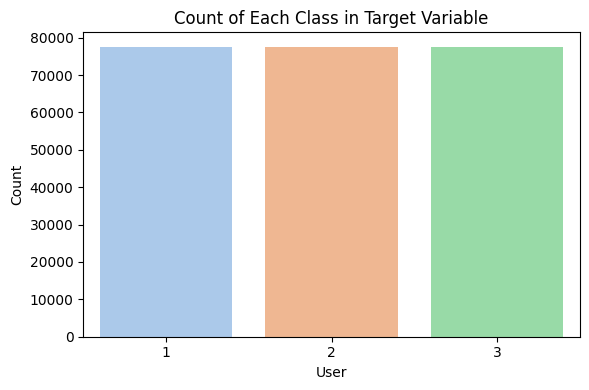

In [427]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df.user, palette="pastel")

plt.title("Count of Each Class in Target Variable")
plt.xlabel("User")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Saving the data

In [428]:
df.to_csv('data/dataFile.csv', index=False)